# Image to Monet Cycle GAN

This project aims to solve this [Kaggle Contest](https://www.kaggle.com/competitions/gan-getting-started/overview). I based my code in the following [Cycle GAN Implementation Guide](https://www.kaggle.com/code/ttymonkey/cyclegan-starter).

## Objective

The main objective of this contest is to generate Monet images from normal images. Submit your generated images and be top target in the leaderboard.

## Architecture

I run this notebook using my ASUS TUF Gaming Laptop with a 3050 NVIDIA Geforce RTX Card with 4GB of Graphic memory and 32 GB of RAM.

## Initial imports

I will need some libraries for data processing and PyTorch for easy to use training a Cycle GAN.

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
from collections import defaultdict

import random
from torch.utils.data import Dataset, DataLoader

## Used Folders listing

In [2]:
root_path = "../data/gan-getting-started"
os.listdir(root_path)

['monet_tfrec', 'photo_tfrec', 'monet_jpg', 'photo_jpg']

## Data Exploration

First, I want to see what type of image I am dealing with, the size and ways of how to read it and processes it.

In [3]:
read_img = lambda path: cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

In [4]:
data_path = f"{root_path}/photo_jpg"
sample_photo = read_img(os.path.join(data_path, os.listdir(data_path)[0]))

data_path = f"{root_path}/monet_jpg"
sample_monet = read_img(os.path.join(data_path, os.listdir(data_path)[0]))

In [5]:
sample_photo.shape

(256, 256, 3)

In [6]:
sample_photo.min(), sample_photo.max(), sample_photo.dtype

(0, 255, dtype('uint8'))

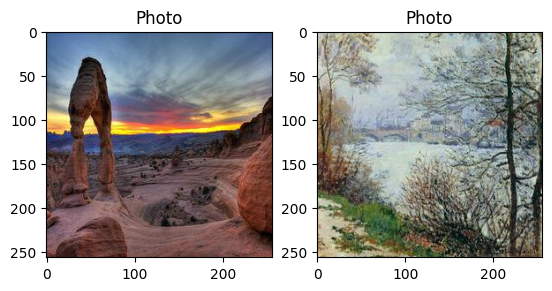

In [7]:
plt.subplot(121)
plt.title("Photo")
plt.imshow(sample_photo)  

plt.subplot(122)
plt.title("Photo")
plt.imshow(sample_monet)  

## Cycle GAN Implementation

A cycle GAN is similar to the traditional GAN architecture, but it do not need equivalent pairs of images to learn the context of the desired output. Such as the example above shows, it not exist equivalent pairs in this dataset.

### Initialization

The size of the images are 256x256 images with 3 channels, I will save it in the following global variables.

In [8]:
IMG_H, IMG_W, IMG_C = 256, 256, 3

And then starting the implementation...

### Downsampling

The first part of a traditional Cycle GAN architecture is the downsampling, it reduces the resolution of the images giving the network the most relevant information of the image.

In [9]:
def downsample(in_channels, out_channels, kernel_size, norm=True):
    downsample_block = [nn.Conv2d(in_channels=in_channels,
                                  out_channels=out_channels,
                                  kernel_size=kernel_size,
                                  stride=2,
                                  padding=(kernel_size - 1) // 2,
                                  bias=False)
                       ]
    if norm:
        downsample_block.append(nn.GroupNorm(num_groups=out_channels,
                                             num_channels=out_channels))
    
    downsample_block.append(nn.LeakyReLU())
    return nn.Sequential(*downsample_block)

In [10]:
x = torch.randn(1,IMG_C, IMG_H, IMG_W)

out = downsample(3, 3, 3)(x)

assert IMG_C == out.shape[1] 
assert IMG_H == out.shape[2] * 2
assert IMG_W == out.shape[3] * 2

### Upsampling 
You can define the upsamplig step as the oposite of upsampling. From information, it upscales the image genereting a new one.

In [11]:
def upsample(in_channels, out_channels, kernel_size, dropout=False):
    downsample_block = [nn.ConvTranspose2d(in_channels=in_channels,
                                           out_channels=out_channels,
                                           kernel_size=kernel_size,
                                           stride=2,
                                           padding=(kernel_size - 1) // 2,
                                           bias=False),
                        nn.GroupNorm(num_groups=out_channels,
                                     num_channels=out_channels)
                       ]
    if dropout:
        downsample_block.append(nn.Dropout(0.5))
    
    downsample_block.append(nn.ReLU())
    return nn.Sequential(*downsample_block)

In [12]:
x = torch.randn(1,IMG_C, IMG_H, IMG_W)

out = upsample(3, 3, 4)(x)

assert IMG_C == out.shape[1] 
assert IMG_H == out.shape[2] // 2
assert IMG_W == out.shape[3] // 2

Usually, it is needed to initialize the network convolutional layers with random values, the following cell do this.

In [13]:
def weight_init(m):
    if any(isinstance(m, _m) for _m in [nn.Conv2d, nn.ConvTranspose2d]):
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

### Generator

It is the part of the layer that generates new images from the information.

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = self._init_encoder()
        self.decoder = self._init_decoder()
        
        self.out = nn.ConvTranspose2d(in_channels=128,
                                      out_channels=3,
                                      kernel_size=4,
                                      stride=2, padding=1)
        self.act = nn.Tanh()
        
        self.apply(weight_init)
        
    def forward(self, x):
        
        skips = [] 
        for layer in self.encoder:
            x = layer(x)
            skips.append(x)
        
        skips = reversed(skips[:-1])
        
        for layer, skip in zip(self.decoder, skips):
            x = layer(x)
            x = torch.cat((x, skip), dim=1)
                
        out = self.act(self.out(x))
        
        return out
        
        
    def _init_encoder(self):
        kernel_size = 4
        in_channels = 64
        
        out_channels = [128, 256, 512, 512, 512, 512]
        
        encoder = [downsample(in_channels=3, out_channels=in_channels, 
                              kernel_size=kernel_size, norm=False)]
        
        for out_ch in out_channels:
            encoder.append(downsample(in_channels=in_channels, out_channels=out_ch,
                                      kernel_size=kernel_size))
            in_channels = out_ch
        
        return nn.Sequential(*encoder)
    
    def _init_decoder(self):
        base_channels = 512
        kernel_size = 4
        in_channels = [512, 1024, 1024, 1024, 512, 256]
        
        out_channels  = [512, 512, 512, 256, 128, 64]
        dropout = [True, True, True, False, False, False]
        
        decoder = [upsample(in_channels=in_ch, out_channels=out_ch, 
                            kernel_size=kernel_size, dropout=drop) 
                   
                   for in_ch, out_ch, drop in zip(in_channels, out_channels, dropout)]
        
        
        return nn.Sequential(*decoder)

In [15]:
g = Generator()
x = torch.randn(1,3,256,256)

enc_out = g.encoder(x)
gen_out = g(x)

assert enc_out.shape[1] == 512
assert enc_out.shape[2] == x.shape[2] // 128
assert enc_out.shape[3] == x.shape[3] // 128

assert gen_out.shape[1] == x.shape[1]
assert gen_out.shape[2] == x.shape[2]
assert gen_out.shape[3] == x.shape[3]

In [16]:
convolutions = []
for _, m in g.named_modules():
    if isinstance(m, nn.Conv2d):
        convolutions.append(m.weight.flatten().clone().detach().numpy())

convolutions = np.concatenate(convolutions)
convolutions.mean(), convolutions.std()

(5.802678e-06, 0.019999431)

### Discriminator

It is the part of the network which difference fake images from the real ones. In a cycle GAN it is necesary because we need to calculate the loss in some way and the discriminator will gives us this value from its evaluation.

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        base_channels = 64
        kernel_size = 4
        self.discriminator = nn.Sequential(
            downsample(in_channels=3, out_channels=base_channels, 
                       kernel_size=kernel_size, norm=False),
            downsample(in_channels=base_channels, out_channels=base_channels * 2, 
                       kernel_size=kernel_size),
            downsample(in_channels=base_channels * 2, out_channels=base_channels * 4, 
                       kernel_size=kernel_size),
            nn.ZeroPad2d(padding=(0, 2, 0, 2)),
            nn.Conv2d(in_channels=base_channels * 4, out_channels=base_channels * 8,
                      kernel_size=4, stride=1, bias=False),
            nn.GroupNorm(num_groups=base_channels * 8,
                         num_channels=base_channels * 8),
            nn.ZeroPad2d(padding=(0, 2, 0, 2)),      
            nn.Conv2d(in_channels=base_channels * 8, out_channels=1,
                      kernel_size=4, stride=1),
        )
        
        self.apply(weight_init)
        
    def forward(self, x):
        return self.discriminator(x)
    

In [18]:
d = Discriminator()
x = torch.randn(1,3,256,256)

assert d(x).shape[1] == 1

In [19]:
torch_sample = torch.tensor(sample_photo, dtype=torch.float32)

torch_sample = (torch_sample / 255.0 - 0.5) / 0.5

torch_sample = torch_sample.permute(2,0,1)

torch_sample = torch_sample.unsqueeze(dim=0)

### Testing the generator

From initial state, the generator will give some information about the Original Photo.

In [20]:
monet_generator = Generator()

In [21]:
with torch.inference_mode():
    monet_generator.eval()
    to_monet = monet_generator(torch_sample).detach()
    to_monet.shape

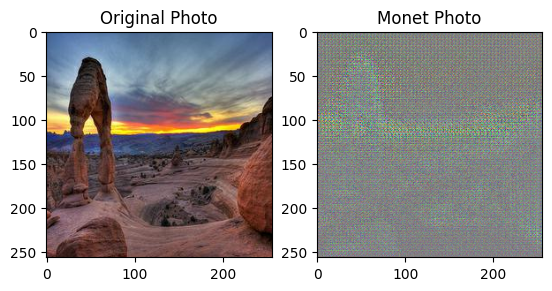

In [22]:
plt.subplot(1,2,1)
plt.title("Original Photo")
plt.imshow(torch_sample[0].permute(1,2,0) * 0.5 + 0.5)

plt.subplot(1,2,2)
plt.title("Monet Photo")
plt.imshow(to_monet[0].permute(1,2,0) * 0.5 + 0.5)

### Cycle GAN implementation

As I mention in the introduction of this section, a Cycle GAN distinguish the field of the desired target looping from one field to another. The basic logic of a Cycle GAN is two GANs competing between each other.

One trying to translate to field (Original -> Monet) and the other with (Monet -> Original.

In the training, both GANs generators are constantly trying to mislead their rivals.

Finally, it is needed to calculate the loss between each type of generated image: fake and original, from every field: normal and Monet. This will give the network a way to generate better images.

In [23]:
class CycleGAN(nn.Module):
    
    def __init__(self, lr=2e-4, lambda_cycle=10):  # Not sure what that is yet
        super().__init__()
        
        self.gen_monet = Generator()
        self.optim_gen_monet = optim.Adam(self.gen_monet.parameters(),
                                          lr=lr,
                                          betas=(0.5, 0.999))
        self.gen_photo = Generator()
        self.optim_gen_photo = optim.Adam(self.gen_photo.parameters(),
                                          lr=lr,
                                          betas=(0.5, 0.999))
        
        self.disc_monet = Discriminator()
        self.optim_disc_monet = optim.Adam(self.disc_monet.parameters(),
                                          lr=lr,
                                          betas=(0.5, 0.999))
        self.disc_photo = Discriminator()
        self.optim_disc_photo = optim.Adam(self.disc_photo.parameters(),
                                          lr=lr,
                                          betas=(0.5, 0.999))
        
        self.loss_l2 = nn.MSELoss()
        self.loss_l1 = nn.L1Loss()
        
        self.lambda_cycle = lambda_cycle
        
    def forward(self, x):
        return self.gen_monet(x)
    
    def forward_step(self, x):
        x_monet, x_photo = x
        
        self.optim_zero_grad()
        
        x_fake_monet = self.gen_monet(x_photo)
        x_fake_photo = self.gen_photo(x_monet)
        
        d_real_monet = self.disc_monet(x_monet)
        d_fake_monet = self.disc_monet(x_fake_monet.detach())
        
        d_real_photo = self.disc_photo(x_photo)
        d_fake_photo = self.disc_photo(x_fake_photo.detach())
        
        d_loss_monet = self.disc_loss(x_real=d_real_monet,
                                      x_fake=d_fake_monet)
        
        d_loss_photo = self.disc_loss(x_real=d_real_photo,
                                      x_fake=d_fake_photo)
        
        d_loss = d_loss_monet + d_loss_photo
        
        d_loss.backward()
        
        self.optim_disc_monet.step()
        self.optim_disc_photo.step()
        
        x_adv_monet = self.disc_monet(x_fake_monet)
        x_adv_photo = self.disc_photo(x_fake_photo)  
        
        x_cycled_monet = self.gen_monet(x_fake_photo)
        x_cycled_photo = self.gen_photo(x_fake_monet)
        
        g_loss_adv_monet = self.loss_l2(torch.ones_like(x_adv_monet), x_adv_monet)
        g_loss_adv_photo = self.loss_l2(torch.ones_like(x_adv_photo), x_adv_photo)
        
        g_loss_cycle_monet = self.loss_l1(x_monet, x_cycled_monet) * self.lambda_cycle
        g_loss_cycle_photo = self.loss_l1(x_photo, x_cycled_photo) * self.lambda_cycle
        
        g_loss_monet = g_loss_adv_monet + g_loss_cycle_monet 
        g_loss_photo = g_loss_adv_photo + g_loss_cycle_photo 
        g_loss = g_loss_monet + g_loss_photo
        
        g_loss.backward()
        
        self.optim_gen_monet.step()
        self.optim_gen_photo.step()
        
        return {
            "g_monet" : g_loss_monet,
            "g_photo" : g_loss_photo,
            "d_monet" : d_loss_monet,
            "d_photo" : d_loss_photo
        }
        
    def disc_loss(self, x_real, x_fake):
        loss_real = self.loss_l2(torch.ones_like(x_real), x_real)
        loss_fake = self.loss_l2(torch.zeros_like(x_fake), x_fake)
        
        return (loss_real + loss_fake) * 0.5
    
    def optim_zero_grad(self):
        self.optim_gen_monet.zero_grad()
        self.optim_gen_photo.zero_grad()
        
        self.optim_disc_monet.zero_grad()
        self.optim_disc_photo.zero_grad()

In [24]:
cycle_gan = CycleGAN()

In [25]:
x_real = torch.ones(1, 3, 256, 256)
x_fake = torch.zeros_like(x_real)
cycle_gan.forward_step((x_real, x_fake))

{'g_monet': tensor(12.2093, grad_fn=<AddBackward0>),
 'g_photo': tensor(25.1488, grad_fn=<AddBackward0>),
 'd_monet': tensor(1.6836, grad_fn=<MulBackward0>),
 'd_photo': tensor(2.0520, grad_fn=<MulBackward0>)}

In [26]:
to_tensor = lambda x: torch.tensor(x, dtype=torch.float32).permute(2,0,1).unsqueeze(0) / 127.5 - 1.0
from_tensor = lambda x: ((x.squeeze().permute(1,2,0).numpy() + 1.0) * 127.5).astype(np.uint8)

In [27]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [28]:
tensor_monet = to_tensor(sample_monet).to(device)
tensor_photo = to_tensor(sample_photo).to(device)

tensor_monet.min(), tensor_monet.max(), tensor_monet.shape, tensor_monet.device

(tensor(-1., device='cuda:0'),
 tensor(1., device='cuda:0'),
 torch.Size([1, 3, 256, 256]),
 device(type='cuda', index=0))

## Dataset Loading

Then I will load the full photos dataset.

In [29]:
class MonetDataset(Dataset):
    def __init__(self, root_path):
        
        self.root_path = root_path
        self.photo_paths = os.listdir(f"{root_path}/photo_jpg")
        self.monet_paths = os.listdir(f"{root_path}/monet_jpg")
        
    def __len__(self):
        return len(self.photo_paths)
    
    def __getitem__(self, idx):
        path_photo = f"{root_path}/photo_jpg/{self.photo_paths[idx]}"
        
        path_monet = f"{root_path}/monet_jpg/{random.choices(self.monet_paths, k=1)[0]}"
        
        x_photo = self.to_tensor(self.read_img(path_photo))
        x_monet = self.to_tensor(self.read_img(path_monet))
        
        return x_monet, x_photo
        
    def to_tensor(self, x):
        return torch.tensor(x, dtype=torch.float32).permute(2,0,1) / 127.5 - 1.0
        
    def read_img(self, path):
        return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

## Training

I will set the number of epochs to 50 and the batch size to 4. Originally the number of epochs was 30 and the batch 32. The main reason to this change is the closeness to desired performance and the 4GB max memory which, during training, it fills 2.4 GB of the total graphic memory.

In [30]:
NUM_EPOCHS = 50
BATCH_SIZE = 4

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

loss_epoch = defaultdict(list)

In [31]:
dataset = MonetDataset(root_path=root_path)
data_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4)

cycle_gan = CycleGAN(lr=1e-6).to(device)
loss_epoch = defaultdict(list)

In [32]:
VALIDATE_EVERY = 0.1 * NUM_EPOCHS
PHOTO_TO_MONET = []

for i in range(1, NUM_EPOCHS + 1):  # Starting at one for tqdm
    
    with tqdm(total=len(data_loader),
          desc=f"Epoch {i}/{NUM_EPOCHS}",
          ascii=True, 
          colour="green") as pbar:
        
        loss_batch = defaultdict(list)
        for x in data_loader:
            x_monet = x[0].to(device)
            x_photo = x[1].to(device)

            loss = cycle_gan.forward_step((x_monet, x_photo))

            for k, v in loss.items():
                loss_batch[k].append(v.item())

            pbar.set_postfix({k:v.item() for k, v in loss.items()})
            pbar.update()
            
        for k, v in loss_batch.items():
            loss_epoch[k].append(np.mean(v))
        
        if i % VALIDATE_EVERY == 0:
            with torch.inference_mode(mode=True):
                cycle_gan.eval()
                monet_pred = cycle_gan(tensor_photo)
            
            PHOTO_TO_MONET.append(monet_pred)
            cycle_gan.train()

Epoch 1/50:   0%|                                                                                                                                                  | 0/1760 [00:00<?, ?it/s]/home/reikia/anaconda3/envs/gan-project/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,
/home/reikia/anaconda3/envs/gan-project/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/reikia/anaconda3/envs/gan-project/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnEx

## Loss Evaluation

In the following figure you will see the Generated images from both GANS and the real ones loss.

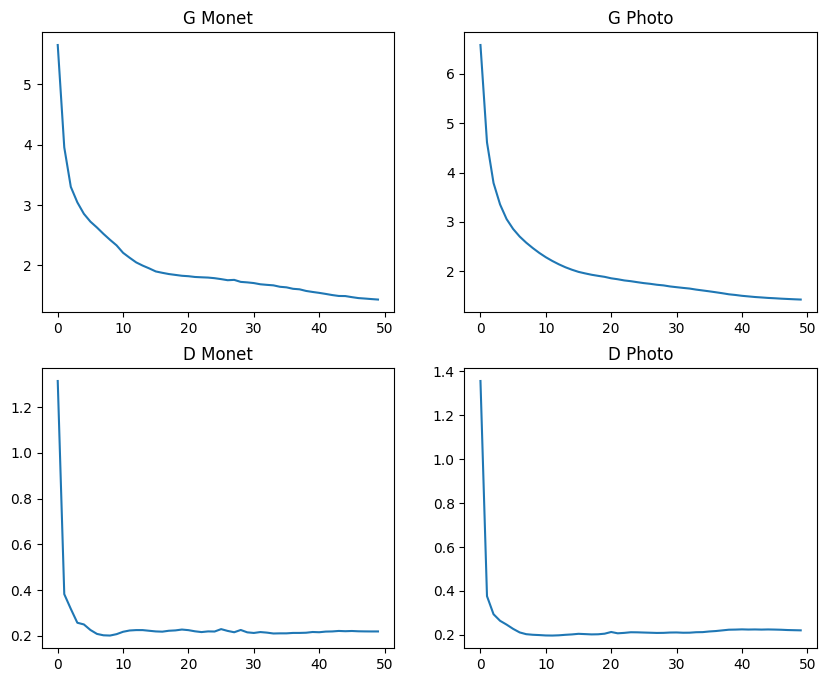

In [33]:
plt.figure(figsize=(10,8))

plt.subplot(221)
plt.plot(range(len(loss_epoch["g_monet"])), loss_epoch["g_monet"])
plt.title("G Monet")

plt.subplot(222)
plt.plot(range(len(loss_epoch["g_photo"])), loss_epoch["g_photo"])
plt.title("G Photo")

plt.subplot(223)
plt.plot(range(len(loss_epoch["d_monet"])), loss_epoch["d_monet"])
plt.title("D Monet")

plt.subplot(224)
plt.plot(range(len(loss_epoch["d_photo"])), loss_epoch["d_photo"])
plt.title("D Photo")

plt.show()

(-0.5, 255.5, 255.5, -0.5)

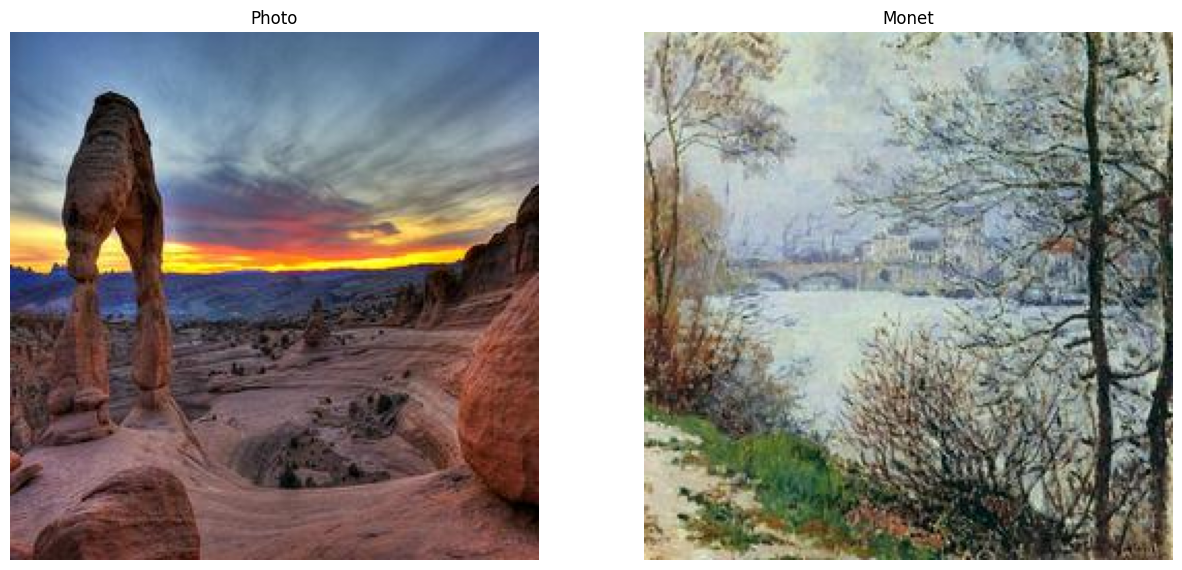

In [34]:
plt.figure(figsize=(15,10))

plt.subplot(121)
plt.title("Photo")
plt.imshow(from_tensor(tensor_photo.cpu()))
plt.axis("off")

plt.subplot(122)
plt.title("Monet")
plt.imshow(sample_monet)
plt.axis("off")

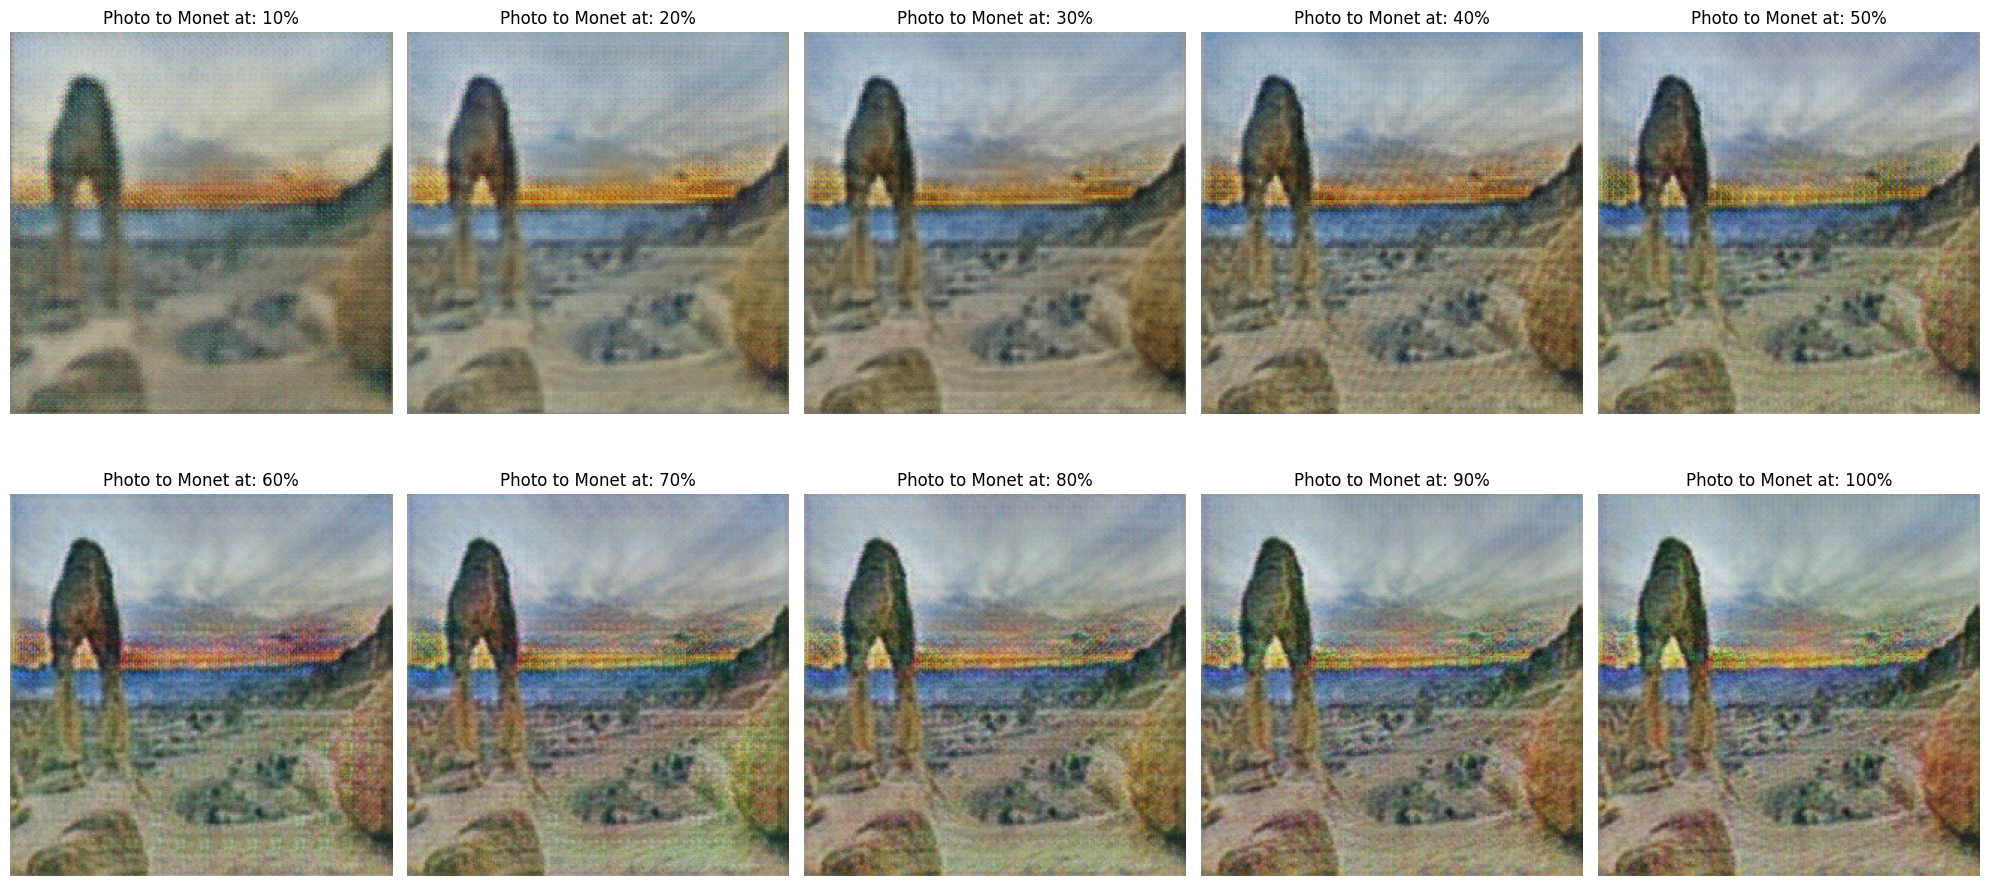

In [35]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

axes = axes.flatten()

for i, img in enumerate(PHOTO_TO_MONET):
    axes[i].imshow(from_tensor(img.cpu()))
    axes[i].axis('off')
    axes[i].set_title(f"Photo to Monet at: {(i+1) * 10}%")

plt.tight_layout()
plt.show()

## Ouput saving

Finally, I will save the output images in my repository.

In [36]:
import PIL
! mkdir ../images
! mkdir ../results

In [37]:
i = 1
data_loader = DataLoader(dataset=dataset, batch_size=1)
with torch.inference_mode(mode=True):
    cycle_gan.eval()
    
    for x in data_loader:
        photo, _ = x
        
        pred = cycle_gan(photo.to(device)).cpu().squeeze().numpy()
        pred = np.transpose(pred, (1,2,0))
        
        pred = (pred * 127.5 + 127.5).astype(np.uint8)
        
        pred_img = PIL.Image.fromarray(pred)
        pred_img.save("../images/" + str(i) + ".jpg")
        
        i += 1

In [40]:
import shutil
shutil.make_archive("../images", 'zip')

'../images.zip'

## Conclusions

In this notebook I implemented a Cycle GAN using PyTorch. For the contest submission, the evaluator asks you to upload our code in the Kaggle environment, this will achieved as next steps. In future works, it is possible to evaluate different architectures varying from convolutions to fully conected layers.